**Complete the details below:**

### Name: Ryno Swart


#### Student Number: 18603637

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [27]:
import math
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import HTML
from IPython.display import display
from IPython.display import Image
from sklearn.metrics import confusion_matrix
from hmm_class import HMM
from gaussian import Gaussian
from utils import read_signatures, sign_norm

# Hidden Markov Models (HMMs)

Up to this point all the data we have worked with has been treated as i.i.d.---i.e. all the different observations were viewed as independent from each other---even when this clearly is not the case, such as with the signature data where each coordinate depends on past coordinates. 

One of the most fundamental tasks of machine learning is to model dependencies between variables. HMMs have been designed to do just this. These days we know that HMMs are just a particularly simple example of a more general class of models, namely Probabilistic Graphical Models. 

HMMs model dynamic processes, or processes that can be thought of as being dynamic. In practice this means that we observe a dynamic process that provides us with observations (or samples) at successive time instances. Signatures are good examples: At fixed intervals, the tablet registers the $x$ and $y$ coordinates of the pen (among other things). Plotted in sequence, we display the signature. 

For the HMM model, the idea is that at each time instant generating an observation, the system is in one of a finite set of $k$ (emitting) states. This means that we are dealing with discrete states. Although we do not investigate it here, it is also possible to assume continuous states, a situation modeled by the Kalman filter. In either case, the state sequence, as one proceeds from one time instance to the next, is hidden (unknown), hence the *Hidden* in Hidden Markov models.

Each emitting state is associated with a probability density function (pdf). We will use univariate Gaussian functions for simplicity; a more general choice would be Gaussian Mixture Models (GMMs). The model then specifies that the observation generated by an emitting state is obtained by sampling from the state's pdf.  Thus the data we observe in practice is viewed as being generated by sampling the pdf's of the emitting states, while the underlying state changes over time.

It is convenient to work with additional, non-emitting states, as well.  For this course, the initial and final states, numbered -1 and  $k$ are non-emitting. 

The parameters associated with an HMM, and which need to be learned from training data, are

* The transition probabilities $A_{ij}$ where $A_{ij}$ is the probability that the system will next enter state $j$, if it is currently in state $i$. This is what makes it a *Markov* model, since the next state is only determined by the previous state, and not earlier ones. In its context of PGMs, it is conceptually not hard to generalize to higher order models, but we will only concern ourselves with first order models. Also note that it is possible to remain in the same state, i.e. $A_{ii}$ is not necessarily zero. Note that in principle there is no limitation on how to proceed between states. The implementation you will use in this assignment allows only a left-to-right model, however. That means that from state $i$ one can only proceed to state $j$ if $j\geq i$. Finally note that the $A_{ij}$ are probabilities and therefore normalized so that $\sum_j A_{ij} = 1$.  An additional row and column are added to the bottom and right of $A$ in the code, to model transitions from the initial non-emitting state and into the final non-emitting state respectively.
* As mentioned above, each emitting state is associated with a pdf, in our case only a single Gaussian. The pdf's also need to be estimated during the training stage. This phase is sensitive to strange situations where not enough data is associated with a specific hidden state, leading to degenerate Gaussians and similar problems.  The code may thus discard unused emitting states during the training process.
* HMMs are *generative* models, i.e. it is possible to draw samples from a trained HMM. For example, for a signature verification system a model might be developed from the available signatures of each signatory.  Then it is possible to generate sample "signatures" which resemble the training data from the perspective of the model.

### Training

Usually we'll be given several training sequences produced by the same entity, e.g. several examples of the signatures of a single signatory will be available. The next step is to choose the number of emitting states $k$. This usually requires experimentation using a validation set. Assume that it is known.

The training again proceeds using an EM algorithm called Viterbi re-estimation. The basic idea is simple:
* First estimate or guess the transition probabilities as well as the pdf's associated with each state.
* Use the present estimate of the HMM parameters to fit an observation sequence to the model. This is done by the Viterbi algorithm that finds the optimal state sequence for the observation sequence. Keep a record of the obervations that are assigned to each state. Also keep a count of the number of state transitions. Accumulate this by fitting all the training sequences to the model. After all the training sequences have been used, each state should have a number of observations assigned to it. (If there is an empty state, it should be deleted). The observations associated with a state are used to estimate the pdf of that state. Since counts are available for the state transitions, they only need to be normalized in order to find the state transition probabilities.
* With a new estimate of the HMM available, the process is repeated until convergence.

(Note that unlike the EM algorithm for fitting a GMM, which used responsibilities to allocate data points to multiple clusters, observations are assigned fully to one of the emitting states.  A similar partial (or soft) allocation strategy exists that can be used for HMM training, called the Baum-Welch algorithm.)

### The Viterbi and forward algorithms

Given an observation sequence, the Viterbi algorithm finds the optimal state transition sequence that explains the observations. This really lies at the heart of the HMM. We explained above how crucial the Viterbi algorithm is during training. It lies also at the heart of inference.

Assume that we have built probabilistic models of a number of signatories. If your client is a major bank, this can run into the millions. For signature verification, you are presented with a signature sequence as well as a claim about the identity of the signatory. The task of the system is to verify this claim. That means that the signature, i.e. the observation sequence, needs to be fitted to the claimed model. If it is a good fit, the signature is accepted. Otherwise it is rejected. It is not so straightforward to decide what is a good fit and we will not pursue that question here. We need to fit the signature to the model. The algorithm we use for this is the forward algorithm which returns the likelihood of the observed sequence under the model. Since a likelihood is returned (and not a probability), it is not so easy to decide what is an acceptable fit to accept the sequence, as alluded to above.  (Further, since the likelihood depends on the length of the sequence, it is common to normalize the (log-)likelihood with respect to the number of observations.)

### Software

`scikit-learn` does not have an HMM implementation; instead the software you will use here is our own implementation for left-to-right topologies with Gaussian emission densities.  Please let us know about any issues or errors!  (However, you may also be interested in investigating or experimenting with HMMlearn.)

**The version of the code you are provided with has some sections stripped out for you to complete - see the instructions below.**

### A simple example

As a simple example to see what is happening, let us consider a simple example, based on the example in the code comments. Here we provide the system with 2 sequences of 1-dimensional observations for training, the first with 11 observations, and the second with 7.

By observation of the signals, it should not be hard to see that the data is roughly clustered around 3 values, namely 1.0, 0.1 and 3.5. We therefore specify 3 states.  Fitting the model yields transition probabilities between the states, as well as the parameters (means and covariances) of the Gaussian densities associated with each state.

We print the trained HMM parameters - **verify that they make sense to you.  Ensure you understand what the last row and column in the transition table are for.**

In [3]:
# Define signals
signal1 = np.array([[ 1. ,  1.1,  0.9, 1.0, 0.0,  0.2,  0.1,  0.3,  3.4,  3.6,  3.5]])
signal2 = np.array([[0.8, 1.2, 0.4, 0.2, 0.15, 2.8, 3.6]])

# Collect training data together
toy_data = np.hstack([signal1, signal2])
toy_lengths = [11, 7]

# Create and fit HMM model to data
toy_hmm = HMM()
toy_hmm.fit(toy_data,toy_lengths, 3)


toy_means = [d.get_mean() for d in toy_hmm.dists]
toy_covs = [d.get_cov() for d in toy_hmm.dists]
print ('Transition probabilities: ')
print (toy_hmm.trans)
print ('Means: ')
print (toy_means)
print ('Covariances: ')
print (toy_covs)

Transition probabilities: 
[[ 0.66666667  0.33333333  0.          0.        ]
 [ 0.          0.71428571  0.28571429  0.        ]
 [ 0.          0.          0.6         0.4       ]
 [ 1.          0.          0.          0.        ]]
Means: 
[array([ 1.]), array([ 0.19285714]), array([ 3.38])]
Covariances: 
[array([[ 0.02]]), array([[ 0.01702381]]), array([[ 0.112]])]


# Preparing the data.

In this assignment, we will apply HMMs to the signature data that we have used in earlier assignments - again using only the $x$- and $y$-components. We read only 3 of the 15 signatures of a signatory in with utils.read_signatures and use them for training. Note how the training signatures are first normalized, and then presented to the system. Note that later you will test a signature classification system using the other 12 signatures for each signatory.

(2, 1644)
[603, 510, 531]


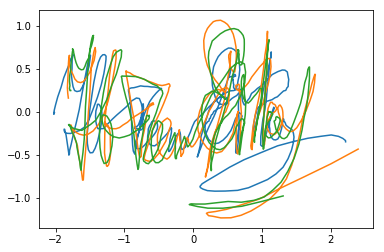

In [4]:
sign = read_signatures('./data/signatures/sign2/*.txt')
n_signs = len(sign)-12
data = sign_norm(sign[0][:2, :])
length = [sign[0].shape[1]]
plt.figure("Signatures: signatory 2")
plt.plot(data[0,:],data[1,:])
for i in range(n_signs-1):
    signi = sign_norm(sign[i+1][:2, :])
    data = np.hstack((data,signi))
    length.append(sign[i+1].shape[1])
    plt.plot(signi[0,:],signi[1,:])
print (data.shape)
print (length)

### Training

**Use the approach above to read in training signatures for each signatory, and train an HMM for each signatory using 5 states and diagonal covariance matrices (we will use most of these models later).**  Note that this is quite a big computation, so can take quite a while.

Marks: 0

In [5]:
sign_hmm = []
for x in np.arange(5):
    sign = read_signatures('./data/signatures/sign' + str(x+1) + '/*.txt')
    n_signs = len(sign)-12 #Only use 3 signatures
    data = sign_norm(sign[0][:2, :])
    length = [sign[0].shape[1]]
    for i in range(n_signs-1):
        signi = sign_norm(sign[i+1][:2, :])
        data = np.hstack((data,signi))
        length.append(sign[i+1].shape[1])
    #Create HMM
    sign_hmm.append(HMM(diagcov=True))
    sign_hmm[x].fit(data, length, 5)

### Sampling from an HMM

Since an HMM is a generative model, one is able to sample from the model to generate data from the distribution represented by the model.  This process interleaves sampling state transitions and observations from the corresponding state's emission density until a transition to the final non-emitting state is reached.

**Complete the implementation of the sample function in the HMM class provided in this assignment, and use it to sample two signals from the model for signatory 2.  Plot the sampled signals in separate images, colouring each point based on its associated state.  (You may simply cycle through the provided list of the 7 pre-defined colors of matplotlib below.).  (Show the transitions from one time step to the next, not just a collection of points).**

*Note that for this question, you must edit and reload the provided hmm_class.py python file.*

Marks: 2

(618, 2)


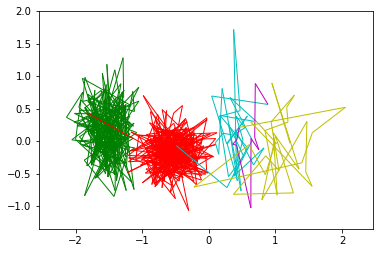

In [10]:
from matplotlib.collections import LineCollection
from matplotlib.colors import ListedColormap, BoundaryNorm
col_list = ['g', 'r', 'c', 'm', 'y', 'k', 'b']
cmap = ListedColormap(col_list[:5])
norm = BoundaryNorm([-0.5, 0.5, 1.5, 2.5, 3.5, 4.5], cmap.N)
samples, states = sign_hmm[1].sample()
points = samples.reshape(-1, 1, 2)
segments = np.concatenate([points[:-1], points[1:]], axis=1)

#Create linecollection with coloured segements
lc = LineCollection(segments, cmap=cmap, norm=norm)
lc.set_array(states[1:])
lc.set_linewidth(1)

#Plot the figure
fig1 = plt.figure()
plt.gca().add_collection(lc)
xmax = np.max(samples[:,0])
xmin = np.min(samples[:,0])
ymax = np.max(samples[:,1])
ymin = np.min(samples[:,1])
xrange = xmax-xmin
yrange = ymax-ymin
plt.ylim(ymin-0.1*yrange, ymax+0.1*yrange)
plt.xlim(xmin-0.1*xrange, xmax+0.1*xrange)
plt.show()

### Fitting a new signal to the model

Once one has a model (or multiple models), one may obtain a new observation.  An important question is then associating different parts of the signals with the underlying states.  This is achieved by the Viterbi algorithm.  To illustrate this, we continue with two signals for our toy example:

In [11]:
signal3 = np.array([[ 0.9515792,   0.9832767,   1.04633007,  1.01464327,  0.98207072,  1.01116689,
  0.31622856,  0.20819263,  3.57707616]])
seq3, ll3 = toy_hmm.viterbi(signal3)
print(seq3)
print(ll3)

signal4 = np.array([[ 1,   0.6,   0.5 , 3.57707616]]) 
seq4, ll4 = toy_hmm.viterbi(signal4)
print(seq4)
print(ll4)

[0 0 0 0 0 0 1 1 2]
2.23881485357
[0 0 1 2]
-7.24978056432


Note that the code above also gives the most likely sequence of states for the given model, not necessarily the true underlying state sequence.  **It is instructive to work through the steps of last example with a calculator or in the Python interpreter, to ensure you do not make common errors which would lead to returning the erroneous sequence [0 1 1 2].** (Nothing need be submitted in this regard.)

### Visualise the different states - Viterbi on signatures

It is instructive to visualise the assignment of the observations to the different classes for signatures.

**Take 2 arbitrary training signatures from different signatories (not signatory 2 as in the example below), allocate the points to states using the Viterbi algorithm, and display the points in the signatures on separate plots, colouring each point based on its associated state. The resulting images should look like the example below (except that it used 10 hidden states):**

**Marks: 2**

In [12]:
display(Image(filename='./hmm1.png'))

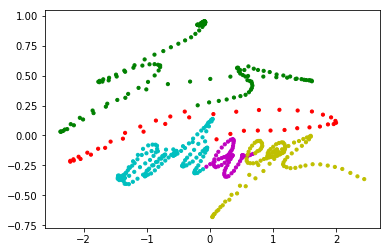

In [13]:
signa = [1, 5]
sig = 7
for i in np.arange(np.size(signa)):
    sign = read_signatures('./data/signatures/sign' + str(signa[i]) + '/*.txt')
    data = sign_norm(sign[sig][:2, :])
    s, ll = sign_hmm[signa[i]-1].viterbi(data)
    #print(s)
    cols = np.empty(np.size(s), dtype="str")
    for x in np.arange(np.max(s)+1):
        cols[s==x] = col_list[x]
    #print(cols)
    plt.scatter(data[0,:],data[1,:], c=cols, s=10)
    plt.show()

### Calculating likelihoods

Note that the Viterbi algorithm also returns the joint log-likelihood of the observed signal and the sequence identified by the algorithm.  However, we may also be interested in this joint log-likelihood for some other sequence, or the (marginal) log-likelihood of the observation.  **Thus you must implement two functions in the HMM class which are documented in the code, namely _score and _forward.**  You can verify your score function by ensuring it returns the same log-likelihood as the viterbi function on the sequence identified by the Viterbi algorithm.  You can check your forward algorithm by explicitly scoring all the possible sequences for a short signal (such as the 4-observation toy example earlier in this notebook) and ensuring the sum of the corresponding likelihoods corresponds to the (marginal) log-likelihood returned by the forward algorithm.  *For this question, you must again edit and reload the provided hmm_class.py python file.  **Include the code cell below and its output in your submission.** *

*Note: when using the forward algorithm, you often need to add likelihoods together with vastly differing magnitudes.  This can lead to inaccuracy, overflow, underflow, and general numerical computation nastiness.  To avoid much of this unpleasantness, you will likely want to make use of numpy's logaddexp function.*

Marks: 2 for score, 2 for forward.

In [28]:
print(toy_hmm.score(signal3, [0, 0, 0, 0, 0, 1, 1, 1, 2]))
print(toy_hmm.score(signal4, [0,1,1,2]))
print(toy_hmm.forward(signal3))
print(toy_hmm.forward(signal4))

-17.275994398
-7.96885938689
2.23882615241
-6.85288483687


# Signature classification

We now turn to classifying signatures known to come from a specific group of individuals, or signature classification.  Note that signature verification is a broader problem, where one must detect whether a signature belongs to a specific individuals - this poses complications we do not discuss further here.

For this section, we use the HMM models built earlier for our signatories, and use them to classify the 5 test signatures of each individual.  **Assuming each signatory is equally likely a priori, classify each signature using these models, and provide a confusion matrix and the test accuracy of the classifier**.

In theory, the likelihood of a signature is calculated with the forward algorithm, but it is also common to use the likelihood of the most likely sequence extracted from the Viterbi algorithm.  For this task, use the latter approach by default.

Marks: 2

In [15]:
def plot_confusion_matrix(cm, title='Confusion matrix', target_names = np.array(['1', '2', '3', '4', '5']), cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(target_names))
    plt.xticks(tick_marks, target_names, rotation=45)
    plt.yticks(tick_marks, target_names)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

[[12  0  0  0  0]
 [ 0 12  0  0  0]
 [ 0  0 12  0  0]
 [ 0  0  1 11  0]
 [ 0  0  0  0 12]]


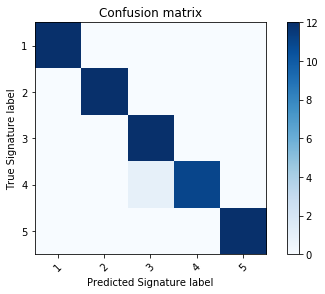

In [23]:
true_labels = np.empty(5*12)
predicted_labels = np.empty(5*12)
for x in np.arange(5):
    sign = read_signatures('./data/signatures/sign' + str(x+1) + '/*.txt')
    for i in np.arange(12):
        signi = sign_norm(sign[i+3][:2, :])
        lls = np.empty(5)
        for h in range(np.size(sign_hmm)):
            seq, ll = sign_hmm[h].viterbi(signi)
            lls[h] = ll
        true_labels[i+12*x] = x
        predicted_labels[i+12*x] = np.argmax(lls)

conf = confusion_matrix(true_labels, predicted_labels)
print(conf)
plot_confusion_matrix(conf)
plt.ylabel('True Signature label')
plt.xlabel('Predicted Signature label')
plt.show()

**Note: Include the code you wrote for the functions you completed in the report in (unexecuted) code blocks at the appropriate section.**

# Plagiarism declaration

** Add the plagiarism declaration from the University's Plagiarism Policy in this cell.**

### Plagiarism Declaration

- I have read and understand the Stellenbosch University Policy on Plagiarism and the definitions of
plagiarism and self-plagiarism contained in the Policy [Plagiarism: The use of the ideas or material
of others without acknowledgement, or the re-use of one’s own previously evaluated or published
material without acknowledgement or indication thereof (self-plagiarism or text-recycling)].
- I also understand that direct translations are plagiarism.
- Accordingly all quotations and contributions from any source whatsoever (including the internet)
have been cited fully. I understand that the reproduction of text without quotation marks (even
when the source is cited) is plagiarism.
- I declare that the work contained in this assignment is my own work and that I have not previously
(in its entirety or in part) submitted it for grading in this module/assignment or another
module/assignment.